<a href="https://colab.research.google.com/github/ueki5/colaboratory/blob/main/playground-014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
!pip install japanize-matplotlib | tail -n 1
!pip install plotly | tail -n 1


元データ (150, 4) (150,)
対象データ (100, 2) (100,)
(70, 2) (30, 2) (70,) (30,)


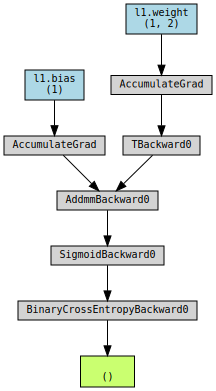

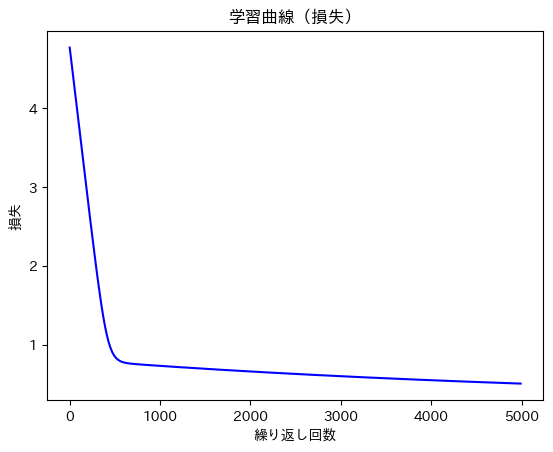

/tmp/ipython-input-761462438.py:157: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



Parameter containing:
tensor([[ 0.3278, -0.7877]], requires_grad=True)
Parameter containing:
tensor([0.7028], requires_grad=True)


In [46]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
from torchinfo import summary
from torchviz import make_dot
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# データ準備
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

# データ絞り込み
#  クラス0,1のみ
#  項目 sepal_lengthとsepal_widthのみ
x_data = iris.data[:100, :2]
y_data = iris.target[:100]

# 結果確認
print('対象データ', x_data.shape, y_data.shape)

# 訓練データ、検証データに分割（シャッフルも同時に実施）
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30,
    random_state=123
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# # 散布図の表示（教師データ）
# x_e0 = x_test[y_test == 0]
# x_e1 = x_test[y_test == 1]
# plt.scatter(x_e0[:,0], x_e0[:,1], marker='x', c='b', label='0(setosa)')
# plt.scatter(x_e1[:,0], x_e1[:,1], marker='o', c='k', label='1(versicolor)')
# plt.xlabel('sepal_length')
# plt.ylabel('sepal_width')
# plt.legend()
# plt.show()

###################################################
# 強化学習
###################################################
lr = 0.001  # 学習率
num_epochs = 5000 # 繰り返し回数
num_history = 10 # 履歴採取タイミング

# 学習データ
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float().view(-1,1)

# 検証データ
inputs_t = torch.tensor(x_test).float()
labels_t = torch.tensor(y_test).float().view(-1,1)

# 予測計算クラス
n_input = x_train.shape[1]
n_output = 1
class Net(torch.nn.Module):
  # 初期化
  def __init__(self, n_input, n_output):
    super().__init__()
    # 予測関数を生成
    self.l1 = torch.nn.Linear(n_input, n_output) # 初段
    # 重み、バイアスの初期値を設定
    self.l1.weight.data.fill_(1.0)
    self.l1.bias.data.fill_(1.0)

    # 活性化関数
    self.sig = torch.nn.Sigmoid()

    # 関数合成
    self.net = torch.nn.Sequential(
        self.l1,
        self.sig,
    )

  # 予測関数
  def forward(self, inputs):
    outputs = self.net(inputs)
    return outputs

# 予測計算オブジェクト
net = Net(n_input, n_output)

# 損失関数
criterion = torch.nn.BCELoss()

# 最適化関数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 記録用配列初期化
history = np.zeros((0, 2))

# 繰り返し処理
for epoch in range(num_epochs):

  # 予測計算
  outputs = net(inputs)

  # 損失計算
  loss = criterion(outputs, labels)
  if epoch == 0:
    g = make_dot(loss, params = dict(net.named_parameters()))
    display(g)

  # 勾配計算
  loss.backward()

  # パラメータ調整＆勾配クリア
  optimizer.step()
  optimizer.zero_grad()

  # 学習曲線データの登録
  if epoch % num_history == 0:
    item = np.array([epoch, loss.item()])
    history = np.vstack((history, item))

# 学習曲線グラフ
plt.plot(history[:,0], history[:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.show()

# 散布図の表示（訓練データ）
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
zero = np.zeros(x_t0.shape[0])
data1 = go.Scatter3d(x=x_t0[:,0], y=x_t0[:,1], z=zero,
                    mode='markers',
                    marker=dict(size=3, color='blue', opacity=0.5),
                    name='0(setosa)')
data2 = go.Scatter3d(x=x_t1[:,0], y=x_t1[:,1], z=zero,
                    mode='markers',
                    marker=dict(size=3, color='red', opacity=0.5),
                    name='1(versicolor)')


# データの生成
x = np.outer(np.linspace(4.0, 7.0, 30), np.ones(30))
y = np.outer(np.linspace(2.0, 4.5, 30), np.ones(30)).T
w1 = net.l1.weight.data[0][0]
w2 = net.l1.weight.data[0][1]
b = net.l1.bias.data[0]
z = w1 * x + w2 * y + b
data3 = go.Surface(x=x, y=y, z=z, opacity=0.5)
fig = go.Figure()
fig.add_trace(data1)
fig.add_trace(data2)
fig.add_trace(data3)
# X軸タイトルを指定
fig.update_xaxes(title="sepal_length")
fig.update_yaxes(title="sepal_width") # Y軸タイトルを指定
fig.update_layout(title="散布図（訓練データ）") # グラフタイトルを設定
fig.update_layout(showlegend=True) # 凡例を強制的に表示（デフォルトでは複数系列あると表示）
fig.update_layout(width=1200, height=900) # 図の高さと幅を指定
fig.show()

print(net.l1.weight)
print(net.l1.bias)